In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import time

/Users/margheritarosnati/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
name = '0a148697c.jpg'
labels_file =  "../data/labels/boxes_v2.csv"
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'

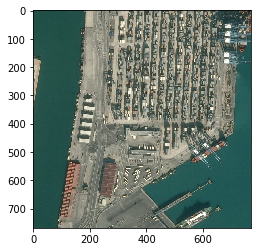

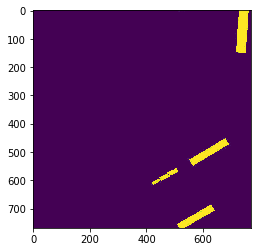

In [3]:
img = mpimg.imread(path + pimg + name)
plt.imshow(img)
plt.show()

gt = mpimg.imread(path + pgt + "gt_" + name)
plt.imshow(gt)
plt.show()

In [4]:
y_raw = pd.read_csv(labels_file)
y_raw[y_raw.ImageId==name]

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
9180,0a148697c.jpg,26,38,557,473,583,511
9181,0a148697c.jpg,150,44,1,715,151,759
9182,0a148697c.jpg,26,36,575,445,601,481
9183,0a148697c.jpg,82,132,685,507,767,639
9184,0a148697c.jpg,23,30,593,418,616,448
9185,0a148697c.jpg,97,140,451,550,548,690


In [5]:
def get_y_data(y_raw, filename):
    '''
    Converts a filename into an array, with one channel for each boat in the image
    :param filename: filename string
    :return: np array of size [h, w, n_boats_in_this_image]
    '''
    ground_truths = y_raw[y_raw.ImageId == filename]
    array_of_coords = np.array(ground_truths[['lt_x', 'lt_y', 'rb_x', 'rb_y']])
    # array_of_coords is of shape [n_boxes, 4]

    n_boxes = array_of_coords.shape[0]
    y_map = np.zeros((768, 768, n_boxes))

    for box_idx in range(n_boxes):
        # Loop over amount of boats per image ~ of order 10.
        box = array_of_coords[box_idx, :]
        # TODO: check that im using dimensions correctly here and agrees with static file
        y_map[box[0]:box[2], box[1]:box[3], box_idx] = 1

    return y_map

In [6]:
y_map = get_y_data(y_raw,name)
y_map.shape

(768, 768, 6)

In [17]:
y_map = tf.convert_to_tensor(y_map, tf.float64)
y_map = tf.reshape(y_map, [1, 768, 768, 6])
y_map = tf.cast(y_map, tf.float64)

## Generating y_class to play with

In [ ]:
#anchor_shapes = [(21,21), (21, 41), (41,21), (41, 81), (81, 41), (51,51), (151,81), (81, 151), (101,101), (201,201)]

In [11]:
anchor_shapes = [(21,21), (201,201)]

In [12]:
iou_positive_threshold = 0.5
iou_negative_threshold = 0.1

In [18]:
# original code
# Here is where we unwrap the y masks to be IOU maps and then maps that match the loss.
y_class = []
selected_boat_index = []
iou_mask = []
n_box = tf.shape(y_map)[-1]

for i, anchor_shape in enumerate(anchor_shapes):
    # Loop over number of anchors ~ of order 9
    # The y_map is of shape [batch_size, h, w, max_n_boats]
    # The kenerl we convolve with is of shape [anchor_shape[0], anchor_shape[1], max_n_boats, max_n_boats]
    # where every entry is 0 except for [:,:, i, i] for all i.
    # (I think) this is equivalent to running a seperate "all ones" [anchor_shape[0], anchor_shape[1], 1]
    # kernel over each of the max_n_boats inputs.
    # TODO: double (triple, quadruple...) check above logic.

    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box))
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box))
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)
    anchor = tf.cast(anchor, tf.float64)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)

    max_iou_over_ground_truth = tf.reduce_max(ious, -1)
    # for the regression ,we need to know which boat we want to look at
    argmax_iou_over_ground_truth = tf.argmax(ious, -1)
    
    #tf.summary.scalar(name='max_gt_iou_' + str(i),
    #                  tensor=tf.reduce_max(max_iou_over_ground_truth))

    #summarise_map(name='iou_' + str(i), tensor=max_iou_over_ground_truth)
    
    labels = tf.greater(max_iou_over_ground_truth, iou_positive_threshold)
    labels = tf.cast(labels, tf.float32)

    # We only deal in both losses with boxes with IOU above a upper threshold and
    # below a lower threshold and so here we create a mask which will be 1 for
    # all such iou scores and 0 for those inside the threshold so we can
    # use it as a weighting for the losses
    iou_mask_anchor = tf.logical_or(
        tf.greater(max_iou_over_ground_truth, iou_positive_threshold),
        tf.less(max_iou_over_ground_truth, iou_negative_threshold)
    )
    # iou_mask shape: [batch, 768, 768, n_proposal_boxes]
    iou_mask.append(tf.cast(iou_mask_anchor, tf.float32))

    y_class.append(labels)
    selected_boat_index.append(argmax_iou_over_ground_truth)

# Stack all the anchors together in the end this is then of shape [batch, 768, 768, n_anchor]
y_class = tf.stack(y_class, axis=-1)
selected_boat_index = tf.stack(selected_boat_index, axis=-1)
#if self.config.debug == 1:
#    print("iou_mask_anchor", iou_mask_anchor.shape)
#    print("iou_mask_anchor", iou_mask_anchor.shape)
#    print('self.y_class.shape', self.y_class.shape)
#    print('selected_boat_index', selected_boat_index.shape)

# Stack IOU masks
iou_mask = tf.stack(iou_mask, -1)

## now that we have y_class, let's look at sampling

In [19]:
with tf.Session() as sess:
    np_y_class = y_class.eval(session=sess)

In [28]:
# calculating np_y_class takes some time, so let's save it
# ... with the ugliest checkpoint ever created using numpy
y_class_checkpoint = tf.convert_to_tensor(np_y_class, tf.float64)

In [29]:
np_y_class.shape, y_class_checkpoint.shape
# now we can have fun

((1, 768, 768, 2),
 TensorShape([Dimension(1), Dimension(768), Dimension(768), Dimension(2)]))

In [40]:
np.sum(np_y_class,axis=(0,1,2))

array([120.,   0.], dtype=float32)

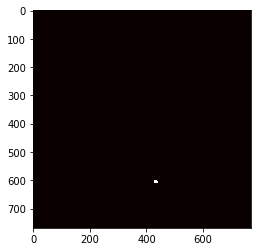

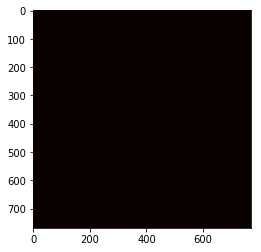

In [35]:
for i in range(2):
    plt.imshow(np_y_class[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

In [42]:
print("sampling : WIP")
# count the number of positive anchors
positives = tf.equal(y_class_checkpoint, 1)
print("positives", positives.shape)
n_positives = tf.reduce_sum(tf.cast(positives, tf.float32), axis=[1, 2])
print("n_positives", n_positives.shape)
negatives = tf.equal(y_class_checkpoint, -1)
n_negatives = tf.reduce_sum(tf.cast(negatives, tf.float32), axis=[1, 2])
print("ratio", n_positives/(n_positives+n_negatives))
# say we aim for ratio 1:2
diff = 2 * n_positives - n_negatives
# diff is the # of n_neg we want to get rid of (most probably, unless we have an image COVERED with boats)
# TODO: check that this is not the case
to_keep = 1 - diff/n_negatives


sampling : WIP
positives (1, 768, 768, 2)
n_positives (1, 2)
ratio Tensor("truediv_8:0", shape=(1, 2), dtype=float32)


In [47]:
with tf.Session() as sess:
    arr = diff.eval(session=sess)
    print("n_negatives", n_negatives.eval(session=sess))

n_negatives [[0. 0.]]


so y_class is not what we want to look at, iou_mask is

## let's calculate iou mask and get back to this

In [48]:
with tf.Session() as sess:
    np_iou_mask = iou_mask.eval(session=sess)

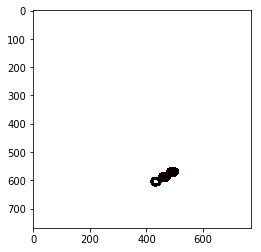

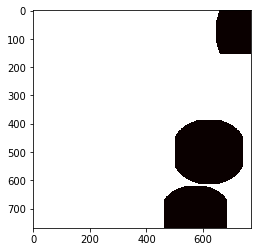

In [49]:
for i in range(2):
    plt.imshow(np_iou_mask[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

In [52]:
ones = np.sum(np_iou_mask==1, axis=(0,1,2))
zeros = np.sum(np_iou_mask==0, axis=(0,1,2))
minones = np.sum(np_iou_mask==-1, axis=(0,1,2))
print(ones,zeros,minones)

[586395 494058] [ 3429 95766] [0 0]


In [50]:
iou_mask_checkpoint = tf.convert_to_tensor(np_iou_mask, tf.float64)

In [51]:
print("sampling : WIP")
# count the number of positive anchors
positives = tf.equal(iou_mask_checkpoint, 1)
print("positives", positives.shape)
n_positives = tf.reduce_sum(tf.cast(positives, tf.float32), axis=[1, 2])
print("n_positives", n_positives.shape)
negatives = tf.equal(iou_mask_checkpoint, -1)
n_negatives = tf.reduce_sum(tf.cast(negatives, tf.float32), axis=[1, 2])
print("ratio", n_positives/(n_positives+n_negatives))
# say we aim for ratio 1:2
diff = 2 * n_positives - n_negatives
# diff is the # of n_neg we want to get rid of (most probably, unless we have an image COVERED with boats)
# to keep is the % of n_negatives to keep
# NOTE: here we are assuming there will be more negatives than positives
to_keep = 1 - diff/n_negatives

sampling : WIP
positives (1, 768, 768, 2)
n_positives (1, 2)
ratio Tensor("truediv_10:0", shape=(1, 2), dtype=float32)


aaaaand IOU mask is not what we want to look at (although it is of notice how many IOUs are considered "neutral"), but its max_iou_over_ground_truth

In [53]:
max_iou_over_ground_truth
with tf.Session() as sess:
    np_max_iou = max_iou_over_ground_truth.eval(session=sess)

In [54]:
ones_zeros_minusones = np.zeros(np_max_iou.shape)
ones_zeros_minusones[np_max_iou<iou_negative_threshold] = -1
ones_zeros_minusones[np_max_iou>iou_positive_threshold] = 1

In [57]:
ones = np.sum(ones_zeros_minusones==1, axis=(0,1,2))
zeros = np.sum(ones_zeros_minusones==0, axis=(0,1,2))
minones = np.sum(ones_zeros_minusones==-1, axis=(0,1,2))
print(ones,zeros,minones)

0 95766 494058


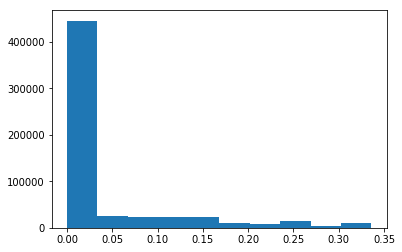

(0.6567162407769097, 0.16236368815104166)

In [66]:
flat_arr = np_max_iou.ravel()
plt.hist(flat_arr)
plt.show()
np.sum(flat_arr==0)/len(flat_arr),np.sum(flat_arr>0.1)/len(flat_arr)

In [55]:
iou_modified_mask = tf.convert_to_tensor(ones_zeros_minusones, tf.float64)

In [56]:
print("sampling : WIP")
# count the number of positive anchors
positives = tf.equal(iou_modified_mask, 1)
print("positives", positives.shape)
n_positives = tf.reduce_sum(tf.cast(positives, tf.float32), axis=[1, 2])
print("n_positives", n_positives.shape)
negatives = tf.equal(iou_modified_mask, -1)
n_negatives = tf.reduce_sum(tf.cast(negatives, tf.float32), axis=[1, 2])
print("ratio", n_positives/(n_positives+n_negatives))
# say we aim for ratio 1:2
diff = 2 * n_positives - n_negatives
# diff is the # of n_neg we want to get rid of (most probably, unless we have an image COVERED with boats)
# to keep is the % of n_negatives to keep
# NOTE: here we are assuming there will be more negatives than positives
to_keep = 1 - diff/n_negatives

sampling : WIP
positives (1, 768, 768)
n_positives (1,)
ratio Tensor("truediv_12:0", shape=(1,), dtype=float32)


from here, the idea is to sample from IOU_mask

ideas: 
- leverage tf.nn.dropout
- use scatter_update (https://stackoverflow.com/questions/35769944/manipulating-matrix-elements-in-tensorflow)

issues with ideas :) :
- dropout drops any random pixel, not just positives or negatives
- we still need to create the mask maybe using tf.boolean_mask?

## Laura's code

In [71]:
# adapting generated code 
labels = np.zeros(np_max_iou.shape)
labels[np_max_iou==0] = -1 # negatives
labels[np_max_iou>0.1] = 1
print(labels.shape)

(1, 768, 768)


In [108]:
startTime = time.time()
idx1 = np.where(labels == 1)
idx1 = np.asarray(idx1)
print("idx1.shape:",idx1.shape)
index = np.random.randint(idx1.shape[1], size=(195766))
print("index.shape:",index.shape)
a = idx1[:, index]
print("a.shape:",a.shape)
a2 = [a[0], a[1], a[2]]
print("a2.shape:",len(a2))
print(np.sum(a2!=a))
mask = np.zeros(labels.shape)
mask[a[0], a[1], a[2]] = 1
print("mask[].shape:",mask[a[0], a[1], a[2]].shape)
print("mask.shape:",mask.shape)
mask[a2] = 1
print("mask.shape:",mask.shape)
print("np.count_nonzero(mask):",np.count_nonzero(mask))
print("labels==1:",np.sum(labels==1))
print("mask*labels==1:",np.sum(mask*labels==1))
print("time:",time.time()-startTime)

idx1.shape: (3, 95766)
index.shape: (195766,)
a.shape: (3, 195766)
a2.shape: 3
0
mask[].shape: (195766,)
mask.shape: (1, 768, 768)
mask.shape: (1, 768, 768)
np.count_nonzero(mask): 83411
labels==1: 95766
mask*labels==1: 83411
time: 0.1421220302581787


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


### After a few tries, let's be lazy and use a tf wrapper around the np code:

In [176]:
### let's try to turn this into a function and maybe it'll work
startTime = time.time()
def sample(labels, label=1, n_samples=180):
    idx1 = np.where(labels == label)
    idx1 = np.asarray(idx1)
    index = np.random.randint(idx1.shape[1], size=(n_samples))
    a = idx1[:, index]
    mask = np.zeros(labels.shape)
    mask[a[0], a[1], a[2]] = label
    return mask
print("time:",time.time()-startTime)

time: 0.0011720657348632812


In [174]:
startTime = time.time()
tf_sample = tf.py_func(sample, [tf_labels],tf.float64)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    arr = tf_sample.eval(session=sess)
print("time:",time.time()-startTime)

time: 3.749556064605713


In [170]:
arr.shape, np.sum(arr==1)

((1, 768, 768), 83428)

now that it works, let's look to make it more truthful to the task

In [ ]:
idx1 = np.where(labels == label)
idx1 = np.asarray(idx1)
index = np.random.randint(idx1.shape[1], size=(180))
a = idx1[:, index]
mask = np.zeros(labels.shape)
mask[a[0], a[1], a[2]] = label

In [ ]:
# adapting generated code 
labels = np.zeros(np_max_iou.shape)
labels[np_max_iou==0] = -1 # negatives
labels[np_max_iou>0.1] = 1
print(labels.shape)

In [ ]:
iou_mask_anchor = tf.logical_or(tf.greater(max_iou_over_ground_truth, 0.1),
                                tf.less(max_iou_over_ground_truth, iou_negative_threshold)

In [175]:
max_iou_checkpoint = tf.convert_to_tensor(np_max_iou, tf.float64)

In [179]:
pos_labels = tf.greater(max_iou_checkpoint, 0.1)
print(pos_labels.shape)
tf_sample = tf.py_func(sample, [pos_labels, 1, 200], tf.float64)

(1, 768, 768)


In [180]:
startTime = time.time()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    arr = tf_sample.eval(session=sess)
print("time:",time.time()-startTime)

time: 4.326807975769043


awesome. Now let's look at the image sampling. To do so we'll have to change y_raw potentially

# Image sampling

In [209]:
# idea: create and load a list with just img and contains boat or not
import os
from sklearn.model_selection import train_test_split

In [204]:
# for all images, what is in and what is out
no_boats = np.unique(np.array(y_raw[y_raw.width==0].ImageId))
some_boats =  np.unique(np.array(y_raw[y_raw.width>0].ImageId))

In [211]:
# data loader loading images
path = "../data/train_sample/"
files = [x for x in os.listdir(path) if x[-3:] == 'jpg']
input_train, input_dev = train_test_split(files, test_size=0.2)

In [219]:
neg_indices = np.isin(no_boats, input_train)
pos_indices = np.isin(some_boats, input_train)


In [226]:
input_pos = list(some_boats[pos_indices])
input_neg = list(no_boats[indices])

In [220]:
some_boats[pos_indices].shape[0] + no_boats[indices].shape[0], len(input_train)

(8000, 8000)

In [224]:
batch_size=4

In [227]:
idx_pos = np.random.choice(len(input_pos), round(batch_size/2))
sub_input_pos = [input_pos[i] for i in idx_pos]
idx_neg = np.random.choice(len(input_neg), round(batch_size/2))
sub_input_neg = [input_neg[i] for i in idx_neg]
sub_input = sub_input_pos + sub_input_neg
random.shuffle(sub_input)

In [228]:
sub_input

['74225f3ba.jpg', '3931e830e.jpg', '7b18390aa.jpg', '2108c79bc.jpg']

In [250]:
labels2 = np.tile(labels.reshape((1,768,768)), (3,1,1))
labels2.shape

(3, 768, 768)

In [254]:
label = 1
n_samples=500
mask = np.zeros(labels2.shape)
idx1 = np.where(labels2 == label)
idx1 = np.asarray(idx1)
print(idx1.shape)
index = np.random.randint(idx1.shape[1], size=(n_samples))
print(index.shape)
a = idx1[:, index]
print(a.shape)
mask[a[0], a[1], a[2], a[3]] = label

(3, 287298)
(500,)
(3, 500)


IndexError: index 3 is out of bounds for axis 0 with size 3

In [253]:
a.shape, idx1.shape, labels.shape, mask.shape

((3, 500), (3, 287298), (1, 768, 768), (3, 768, 768))